In [165]:
import os
import numpy as np
import pandas as pd
import colorcet as cc
from matplotlib import pyplot as plt
from datetime import timedelta


# importing sys
import sys
# adding Code to the system path
sys.path.insert(0, 'D:/LabIREM/codes/python/morphogenesis/morphogenesis_pde/PDE-READ/Data')

from Create_Data_Set import Create_Data_Set;

# Settings for reproducibility
np.random.seed(42)

# Settings for plot

linear_blackwhite= cc.cm.CET_L2
diverging_rainbow = cc.cm.CET_R3

# Settings for signal transformation
curent_directory = 'D:/LabIREM/codes/python/morphogenesis/morphogenesis_pde/PDE-READ/morphogenesis'
SIGNAL_DIR = os.path.join(curent_directory,'wt','projections','signals')
GOLDEN_DIR = os.path.join(curent_directory,'wt','golden')

#
time_average_window = 20
time_average_min_periods = 1
rolling_average_type = 'gaussian'

def time_format_transform(time_frame_stamp):
	td = timedelta(seconds=time_frame_stamp)
	days, hours, minutes = td.days, td.seconds // 3600, td.seconds // 60 % 60
	return str(days * 24 + hours) + "h" + str(minutes).zfill(2)

def time_singleton_stamp_in_seconds(time_stamp):
    return int(sum(x * int(t) for x, t in zip([60, 3600], reversed(time_stamp.split('h')))))

def time_ref_lable_rolling_correction(ref_time_df,label,time_window,time_min_periods):
    time_df = ref_time_df.copy()
    table = []
    for time_frame in range(time_df.shape[0]):
        table.append(time_singleton_stamp_in_seconds(time_df.iloc[time_frame][label]))
    time_df[label+'_in_seconds'] = table
    time_df[label+'_rolling_in_seconds_'] = time_df.loc[:,label+'_in_seconds'].rolling(window = time_window, min_periods = time_min_periods, center=True, axis = 0).mean()
    table = []
    for time_frame in range(time_df.shape[0]):
        table.append(time_format_transform(int(time_df.iloc[time_frame][label+'_rolling_in_seconds_'])))
    time_df[label] = table
    return time_df.drop(columns=[label+'_rolling_in_seconds_'])

def signal_rebase(matrix : pd.DataFrame(), x_ref : np.array(()), t_ref : np.array(()), nb_x : int, nb_t : int, average_window_characteristics):
    average_window = average_window_characteristics[0]
    average_min_periods = 1
    rolling_average_type = 'gaussian'
    sigma_space = average_window_characteristics[3]
    matrix_interpolated_temporal = matrix.copy()
    matrix_interpolated_temporal.reset_index(drop=True, inplace=True)
    x_min = x_ref.min()
    x_max = x_ref.max()
    print('x_min:',x_min)
    print('x_max:',x_max)
    t_min = t_ref.min()
    t_max = t_ref.max()
    print('t_min:',x_min)
    print('t_max:',x_max)
    x_new = np.linspace(x_min, x_max, nb_x)
    t_new = np.linspace(t_min, t_max, nb_t)
    matrix_temporal = []
    for column in range(matrix_interpolated_temporal.columns.size):
        ny = np.interp(x_new, x_ref, matrix_interpolated_temporal[column])
        matrix_temporal.append(ny)
    matrix_temporal_df = pd.DataFrame(matrix_temporal)
    matrix_temporal_df.rolling(window = average_window,
                               min_periods = average_min_periods,
                               win_type = rolling_average_type).mean(std = sigma_space)
    matrix_temporal = []
    for column in range(matrix_temporal_df.columns.size):
        ny = np.interp(t_new, t_ref, matrix_temporal_df[column])
        matrix_temporal.append(ny)
    matrix_new = pd.DataFrame(matrix_temporal)
    matrix_new.rolling(window = average_window,
                       min_periods = average_min_periods,
                       win_type = rolling_average_type).mean(std = sigma_space)
    return x_new, t_new, matrix_new

actual matrix size is 140 x 176, final window will be reduced.
i wont winal window 256 x 200

Shape of grid space_coordinate: (140,)
Shape of grid time_coordinate: (176,)
Shape of grid u_data: (140, 176)
Shape of grid u_data.T: (176, 140)
Shape of grid t: (176, 140)
Shape of grid x: (176, 140)
Shape of grid u: (176, 140)


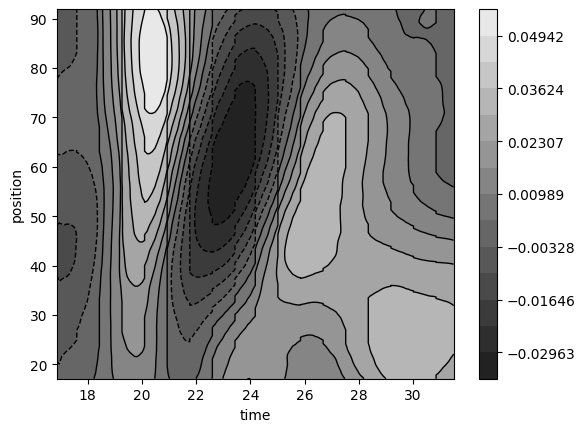

In [112]:
signal_data = pd.read_csv('dataset_experiment/signal_matrix_space_data.csv')
time_data = pd.read_csv('dataset_experiment/plot_time_label_df.csv')
space_coordinate = np.squeeze(signal_data['nx'].values)
print('Shape of grid space_coordinate:', space_coordinate.shape)
time_coordinate = time_data['frame_in_hours'].values
print('Shape of grid time_coordinate:', time_coordinate.shape)
x,t = np.meshgrid(space_coordinate,time_coordinate)
u_data = signal_data.copy()
u_data = u_data.drop(columns=['nx'])
print('Shape of grid u_data:', u_data.shape)
u_transposed = np.real(u_data.T.to_numpy())
print('Shape of grid u_data.T:', u_transposed.shape)

data = {}
data['t'] = t
print('Shape of grid t:', data['t'].shape)
data['x'] = x
print('Shape of grid x:', data['x'].shape)
data['u'] = u_transposed
print('Shape of grid u:', data['u'].shape)

bottom_min  : float = np.min(u_transposed)
bottom_max  : float = np.max(u_transposed)

fig, ax = plt.subplots()
im = ax.contourf(data['t'], data['x'], data['u'], levels = np.linspace(bottom_min, bottom_max, 15), cmap = linear_blackwhite)
#im = ax.imshow(u.T, vmin = bottom_min, vmax = bottom_max, cmap = linear_blackwhite, origin = 'lower', aspect = 1)
ax.contour(data['t'], data['x'], data['u'], levels = np.linspace(bottom_min, bottom_max, 15), colors = 'k', linewidths = 1)
ax.set_xlabel('time')
ax.set_ylabel('position') 
fig.colorbar(mappable=im)
plt.show()

In [113]:
signal_data['nx'].values[2] - signal_data['nx'].values[1]

0.5382733834736442

In [114]:
test = time_coordinate.reshape(-1).astype(dtype = np.float32);
test

array([16.866667, 16.95    , 17.05    , 17.15    , 17.233334, 17.333334,
       17.416666, 17.516666, 17.6     , 17.6     , 17.7     , 17.783333,
       17.883333, 17.983334, 18.066668, 18.166666, 18.25    , 18.35    ,
       18.433332, 18.433332, 18.533333, 18.616667, 18.716667, 18.816668,
       18.9     , 19.      , 19.083334, 19.183332, 19.266666, 19.266666,
       19.366667, 19.45    , 19.55    , 19.65    , 19.733334, 19.833334,
       19.916666, 20.016666, 20.1     , 20.1     , 20.2     , 20.283333,
       20.383333, 20.483334, 20.566668, 20.666666, 20.75    , 20.85    ,
       20.933332, 20.933332, 21.033333, 21.116667, 21.216667, 21.316668,
       21.4     , 21.5     , 21.583334, 21.683332, 21.766666, 21.766666,
       21.866667, 21.95    , 22.05    , 22.15    , 22.233334, 22.333334,
       22.416666, 22.516666, 22.6     , 22.6     , 22.7     , 22.783333,
       22.883333, 22.983334, 23.066668, 23.166666, 23.25    , 23.35    ,
       23.433332, 23.433332, 23.533333, 23.616667, 

In [7]:
# Specify settings.
Data_File_Name      : str   = "Tr_G_WT";
Noise_Proportion    : float = 0.5;

Num_Train_Examples  : int   = 5000;
Num_Test_Examples   : int   = 1000;
# Fetch spatial, temporal coordinates and the true solution. We cast these
# to singles (32 bit fp) since that's what PDE-REAd uses.
t_points    =  time_coordinate.reshape(-1).astype(dtype = np.float32);
print('number t points:',t_points.shape[0])
x_points    =  space_coordinate.reshape(-1).astype(dtype = np.float32);
print('number x points:',x_points.shape[0])
Data_Set    = (np.real(u_transposed)).astype( dtype = np.float32);
print('number points Data_Set:',Data_Set.shape)

number t points: 176
number x points: 140
number points Data_Set: (176, 140)


In [8]:
# Determine problem bounds.
Input_Bounds : np.ndarray    = np.empty(shape = (2, 2), dtype = np.float32);
Input_Bounds[0, 0]              = t_points[ 0];
Input_Bounds[0, 1]              = t_points[-1];
Input_Bounds[1, 0]              = x_points[ 0];
Input_Bounds[1, 1]              = x_points[-1];

In [9]:
# Add noise to true solution.
Noisy_Data_Set = Data_Set + (Noise_Proportion)*np.std(Data_Set)*np.random.randn(*Data_Set.shape);

# Generate the grid of (t, x) coordinates where we'll enforce the "true
# solution". Each row of these arrays corresponds to a particular position.
# Each column corresponds to a particular time.
x_coords_matrix,t_coords_matrix = np.meshgrid(x_points,t_points);
print('number points Noisy_Data_Set:',Noisy_Data_Set.shape)

number points Noisy_Data_Set: (176, 140)


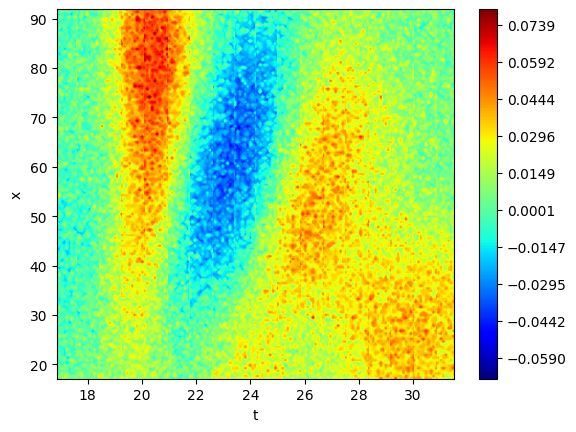

In [10]:
epsilon : float = .0001;
Data_min : float = np.min(Noisy_Data_Set) - epsilon;
Data_max : float = np.max(Noisy_Data_Set) + epsilon;

# Plot!
plt.contourf(t_coords_matrix,
             x_coords_matrix,
             Noisy_Data_Set,
             levels      = np.linspace(Data_min, Data_max, 500),
             cmap        = plt.cm.jet);

plt.colorbar();
plt.xlabel("t");
plt.ylabel("x");
plt.show();

In [11]:
# Now, stitch successive the rows of the coordinate matrices together
# to make a 1D array. We interpert the result as a 1 column matrix.
t_coords_1D : np.ndarray = t_coords_matrix.flatten().reshape(-1, 1);
x_coords_1D : np.ndarray = x_coords_matrix.flatten().reshape(-1, 1);

# Generate data coordinates, corresponding Data Values.
All_Data_Coords : np.ndarray = np.hstack((t_coords_1D, x_coords_1D));
All_Data_Values : np.ndarray = Noisy_Data_Set.flatten();

# Next, generate the Testing/Training sets. To do this, we sample a uniform
# distribution over subsets of {1, ... , N} of size Num_Train_Examples,
# and another over subsets of {1, ... , N} of size Num_Test_Examples.
# Here, N is the number of coordinates.
Train_Indicies : np.ndarray = np.random.choice(All_Data_Coords.shape[0], Num_Train_Examples, replace = False);
Test_Indicies  : np.ndarray = np.random.choice(All_Data_Coords.shape[0], Num_Test_Examples , replace = False);

# Now select the corresponding testing, training data points/values.
Train_Inputs    = All_Data_Coords[Train_Indicies, :];
Train_Targets   = All_Data_Values[Train_Indicies];

Test_Inputs     = All_Data_Coords[Test_Indicies, :];
Test_Targets    = All_Data_Values[Test_Indicies];

# Send everything to Create_Data_Set
DataSet_Name : str = (  Data_File_Name + "_" +
                        "N" + str(int(100*Noise_Proportion)) + "_" +
                        "P" + str(Num_Train_Examples) );

print(DataSet_Name)

Create_Data_Set(    Name            = DataSet_Name,
                        Train_Inputs    = Train_Inputs,
                        Train_Targets   = Train_Targets,
                        Test_Inputs     = Test_Inputs,
                        Test_Targets    = Test_Targets,
                        Input_Bounds    = Input_Bounds);

Tr_G_WT_N50_P5000


In [12]:
os.getcwd()

'D:\\LabIREM\\codes\\python\\morphogenesis\\morphogenesis_pde\\PDE-READ\\morphogenesis'

## Born changes

Shape of grid space_coordinate: (140,)
Shape of grid time_coordinate: (98,)
Shape of grid u_data: (140, 98)
Shape of grid u_data.T: (98, 140)
Shape of grid t: (98, 140)
Shape of grid x: (98, 140)
Shape of grid u: (98, 140)


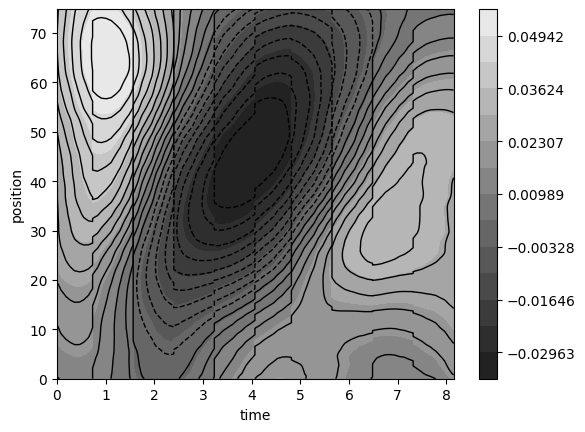

In [154]:
signal_data = pd.read_csv('dataset_experiment/signal_matrix_space_data.csv')
time_data = pd.read_csv('dataset_experiment/plot_time_label_df.csv')
space_coordinate = np.squeeze(signal_data['nx'].values)
print('Shape of grid space_coordinate:', space_coordinate.shape)
time_coordinate = time_data['frame_in_hours'].values
column_start = 30
column_end = 128
time_coordinate = time_coordinate[column_start:column_end]
time_coordinate_offset = time_coordinate.min()
time_coordinate = time_coordinate - time_coordinate_offset
space_coordinate_offset = space_coordinate.min()
space_coordinate = space_coordinate - space_coordinate_offset
print('Shape of grid time_coordinate:', time_coordinate.shape)
u_data = signal_data.copy()
u_data = u_data.drop(columns=['nx'])
x,t = np.meshgrid(space_coordinate,time_coordinate)
u_data = u_data.iloc[:,column_start:column_end].copy()
print('Shape of grid u_data:', u_data.shape)
u_transposed = np.real(u_data.T.to_numpy())
print('Shape of grid u_data.T:', u_transposed.shape)

data = {}
data['t'] = t
print('Shape of grid t:', data['t'].shape)
data['x'] = x
print('Shape of grid x:', data['x'].shape)
data['u'] = u_transposed
print('Shape of grid u:', data['u'].shape)

bottom_min  : float = np.min(u_transposed)
bottom_max  : float = np.max(u_transposed)

fig, ax = plt.subplots()
im = ax.contourf(data['t'], data['x'], data['u'], levels = np.linspace(bottom_min, bottom_max, 15), cmap = linear_blackwhite)
#im = ax.imshow(u.T, vmin = bottom_min, vmax = bottom_max, cmap = linear_blackwhite, origin = 'lower', aspect = 1)
ax.contour(data['t'], data['x'], data['u'], levels = np.linspace(bottom_min, bottom_max, 25), colors = 'k', linewidths = 1)
ax.set_xlabel('time')
ax.set_ylabel('position') 
fig.colorbar(mappable=im)
plt.show()

In [169]:
average_window = 5
average_min_periods = 1
rolling_average_type = 'gaussian'
sigma_space = 4
average_window_characteristics = [average_window, average_min_periods, rolling_average_type, sigma_space]
u_data_copy = u_data.copy()
u_data_copy.columns = range(u_data_copy.shape[1])
u_data_copy.reset_index(drop=True, inplace=True)

In [170]:
x_new, t_new, u_new = signal_rebase(u_data_copy,space_coordinate, time_coordinate, 252, 242, average_window_characteristics)

x_min: 0.0
x_max: 74.82000030283623
t_min: 0.0
t_max: 74.82000030283623


Shape of grid u_data: (252, 242)
Shape of grid u_data.T: (242, 252)
Shape of grid t: (242, 252)
Shape of grid x: (242, 252)
Shape of grid u: (242, 252)


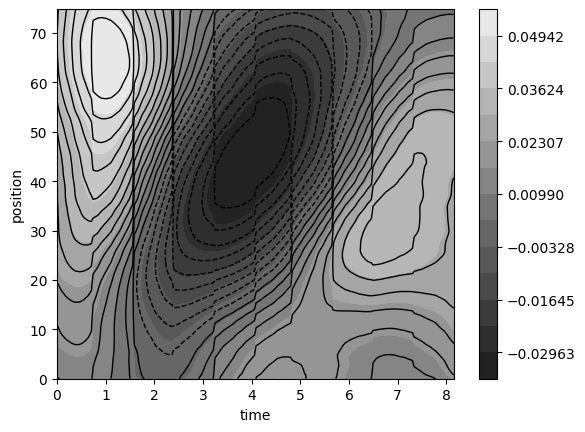

In [172]:
x,t = np.meshgrid(x_new,t_new)
print('Shape of grid u_data:',  u_new.shape)
u_transposed = np.real(u_new.T.to_numpy())
print('Shape of grid u_data.T:', u_transposed.shape)

data = {}
data['t'] = t
print('Shape of grid t:', data['t'].shape)
data['x'] = x
print('Shape of grid x:', data['x'].shape)
data['u'] = u_transposed
print('Shape of grid u:', data['u'].shape)

bottom_min  : float = np.min(u_transposed)
bottom_max  : float = np.max(u_transposed)

fig, ax = plt.subplots()
im = ax.contourf(data['t'], data['x'], data['u'], levels = np.linspace(bottom_min, bottom_max, 15), cmap = linear_blackwhite)
#im = ax.imshow(u.T, vmin = bottom_min, vmax = bottom_max, cmap = linear_blackwhite, origin = 'lower', aspect = 1)
ax.contour(data['t'], data['x'], data['u'], levels = np.linspace(bottom_min, bottom_max, 25), colors = 'k', linewidths = 1)
ax.set_xlabel('time')
ax.set_ylabel('position') 
fig.colorbar(mappable=im)
plt.show()

number t points: 242
number x points: 252
number points Data_Set: (242, 252)
number points Noisy_Data_Set: (242, 252)


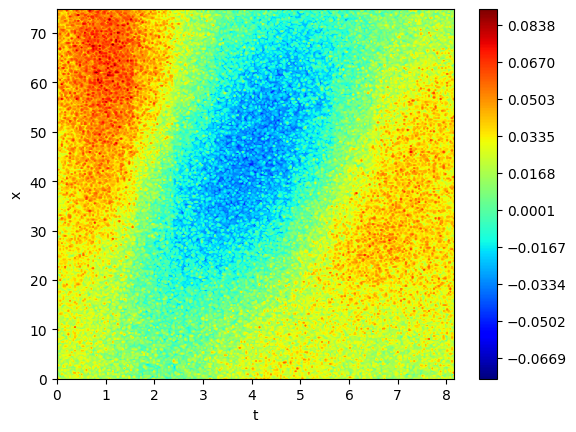

In [179]:
# Specify settings.
Data_File_Name      : str   = "Tr_G_WT_focus";
Noise_Proportion    : float = 0.5;

Num_Train_Examples  : int   = 5000;
Num_Test_Examples   : int   = 1000;
# Fetch spatial, temporal coordinates and the true solution. We cast these
# to singles (32 bit fp) since that's what PDE-REAd uses.
t_points    =  t_new.reshape(-1).astype(dtype = np.float32);
print('number t points:',t_points.shape[0])
x_points    =  x_new.reshape(-1).astype(dtype = np.float32);
print('number x points:',x_points.shape[0])
Data_Set    = (np.real(u_transposed)).astype( dtype = np.float32);
print('number points Data_Set:',Data_Set.shape)

# Determine problem bounds.
Input_Bounds : np.ndarray    = np.empty(shape = (2, 2), dtype = np.float32);
Input_Bounds[0, 0]              = t_points[ 0];
Input_Bounds[0, 1]              = t_points[-1];
Input_Bounds[1, 0]              = x_points[ 0];
Input_Bounds[1, 1]              = x_points[-1];

# Add noise to true solution.
Noisy_Data_Set = Data_Set + (Noise_Proportion)*np.std(Data_Set)*np.random.randn(*Data_Set.shape);

# Generate the grid of (t, x) coordinates where we'll enforce the "true
# solution". Each row of these arrays corresponds to a particular position.
# Each column corresponds to a particular time.
x_coords_matrix,t_coords_matrix = np.meshgrid(x_points,t_points);
print('number points Noisy_Data_Set:',Noisy_Data_Set.shape)

epsilon : float = .0001;
Data_min : float = np.min(Noisy_Data_Set) - epsilon;
Data_max : float = np.max(Noisy_Data_Set) + epsilon;

# Plot!
plt.contourf(t_coords_matrix,
             x_coords_matrix,
             Noisy_Data_Set,
             levels      = np.linspace(Data_min, Data_max, 500),
             cmap        = plt.cm.jet);

plt.colorbar();
plt.xlabel("t");
plt.ylabel("x");
plt.show();

In [180]:
# Now, stitch successive the rows of the coordinate matrices together
# to make a 1D array. We interpert the result as a 1 column matrix.
t_coords_1D : np.ndarray = t_coords_matrix.flatten().reshape(-1, 1);
x_coords_1D : np.ndarray = x_coords_matrix.flatten().reshape(-1, 1);

# Generate data coordinates, corresponding Data Values.
All_Data_Coords : np.ndarray = np.hstack((t_coords_1D, x_coords_1D));
All_Data_Values : np.ndarray = Noisy_Data_Set.flatten();

# Next, generate the Testing/Training sets. To do this, we sample a uniform
# distribution over subsets of {1, ... , N} of size Num_Train_Examples,
# and another over subsets of {1, ... , N} of size Num_Test_Examples.
# Here, N is the number of coordinates.
Train_Indicies : np.ndarray = np.random.choice(All_Data_Coords.shape[0], Num_Train_Examples, replace = False);
Test_Indicies  : np.ndarray = np.random.choice(All_Data_Coords.shape[0], Num_Test_Examples , replace = False);

# Now select the corresponding testing, training data points/values.
Train_Inputs    = All_Data_Coords[Train_Indicies, :];
Train_Targets   = All_Data_Values[Train_Indicies];

Test_Inputs     = All_Data_Coords[Test_Indicies, :];
Test_Targets    = All_Data_Values[Test_Indicies];

# Send everything to Create_Data_Set
DataSet_Name : str = (  Data_File_Name + "_" +
                        "N" + str(int(100*Noise_Proportion)) + "_" +
                        "P" + str(Num_Train_Examples) );

print(DataSet_Name)

Create_Data_Set(    Name            = DataSet_Name,
                        Train_Inputs    = Train_Inputs,
                        Train_Targets   = Train_Targets,
                        Test_Inputs     = Test_Inputs,
                        Test_Targets    = Test_Targets,
                        Input_Bounds    = Input_Bounds);

Tr_G_WT_focus_N50_P5000


In [181]:
250 * 200

50000

## Other analysis

In [13]:
folder_suffix = int(1)
quantity = 'EG_Tr'
signals_processed = pd.read_csv(os.path.join(SIGNAL_DIR,str(folder_suffix),quantity+'.csv'))
signal_processing_time = pd.read_csv(os.path.join(SIGNAL_DIR,str(folder_suffix),'signal_processing_time.csv'))
parameters = pd.read_csv(os.path.join(SIGNAL_DIR,str(folder_suffix),'parameters.csv'))
print(SIGNAL_DIR)
ref_time_label_df = pd.read_csv(os.path.join(GOLDEN_DIR, 'ref_time_label.csv'))
ref_time_label_df['frame_number'] = ref_time_label_df.index
ref_time_label_df['frame_in_seconds'] = ref_time_label_df.loc[:,'time_label'].apply(time_singleton_stamp_in_seconds)
ref_time_label_df['frame_in_hours'] = ref_time_label_df['frame_in_seconds']/3600

D:/LabIREM/codes/python/morphogenesis/morphogenesis_pde/PDE-READ/morphogenesis\wt\projections\signals


In [90]:
plot_time_label_df =  time_ref_lable_rolling_correction(ref_time_label_df,'time_label',time_average_window,time_average_min_periods)

In [91]:
# eqilibrate the matrix with data
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

multiplicative_factor = 1.
print('multiplicative_factor = ',multiplicative_factor)
signal_matrix = signals_processed.loc[:, signals_processed.columns.str.contains('_r_avrg_t')| signals_processed.columns.str.contains('nx')].copy()
signal_matrix_test = signal_matrix.copy()
signal_matrix_test = signal_matrix_test
signal_matrix_test.drop(['nx'], axis=1, inplace=True)
signal_matrix_test.drop(['rolling_nx'], axis=1, inplace=True)
nx_number = signal_matrix_test.shape[0]
min_rolling_nx = signals_processed['rolling_nx'].min()
max_rolling_nx = signals_processed['rolling_nx'].max()
time_min = plot_time_label_df['frame_in_hours'].min()
time_max = plot_time_label_df['frame_in_hours'].max()
time_number = plot_time_label_df.shape[0]
signal_matrix_test_redresed = pd.DataFrame()
nx_redresed = np.linspace(min_rolling_nx,max_rolling_nx,nx_number)
for column in signal_matrix_test.columns:
    ny = np.interp(nx_redresed,signal_matrix['rolling_nx'],signal_matrix_test[column])
    signal_matrix_test_redresed[column] = ny
time_variable = np.linspace(time_min,time_max,time_number)    
signal_matrix_test_redresed_transposed = signal_matrix_test_redresed.T
for column in signal_matrix_test_redresed_transposed.columns:
    ny = np.interp(time_variable,plot_time_label_df['frame_in_hours'],signal_matrix_test_redresed_transposed[column])
    signal_matrix_test_redresed_transposed[column] = ny
signal_matrix_equilibrated = signal_matrix_test_redresed_transposed.T

multiplicative_factor =  1.0


In [92]:


def signal_space_derivative(matrix : pd.DataFrame(),nx : np.array(), nt : np.array(), x_size : int, t_size : int, average_window : int, average_min_periods :int, sigma_space :int):
    """
    
    """
    matrix.dropna(inplace=True)
    matrix.reset_index(drop=True, inplace=True)
    min_nx = nx.min()
    max_nx = nx.max()
    nx_linearized = np.linspace(min_nx, max_nx, x_size)
    new_matrix = pd.DataFrame()
    for column in matrix.columns:
        ny = np.interp(nx_linearized, nx, matrix[column])
        new_matrix[column] = ny
        signal_matrix_dx_averaged[column] = signal_matrix_dx_averaged[column].rolling(window = average_window,
                                                                                           min_periods = average_min_periods,
                                                                                           win_type = rolling_average_type).mean(std = sigma_space)
    signal_matrix_dx_averaged['nx'] = signal_matrix_dx_averaged.loc[:,'nx'].rolling(window = average_window, min_periods = average_min_periods, center=True).mean()
    signal_matrix_dx_averaged = signal_x_common_base(signal_matrix_dx_averaged,'nx',
                                                     signal_matrix_dx_averaged['nx'].min(),
                                                     signal_matrix_dx_averaged['nx'].max(),
                                                     nb_nx_points)
    return signal_matrix_dx_averaged


def signal_space_derivative(signal_matrix : pd.DataFrame(),nb_nx_points : int,average_window : int, average_min_periods :int, sigma_space :int):
    signal_matrix_dx = signal_matrix.copy()
    nx_dx = signal_matrix_dx['nx'].iloc[:-1]
    signal_matrix_dx = signal_matrix_dx.diff()
    signal_matrix_dx['nx_delta'] = signal_matrix_dx['nx']*0.5
    for column in signal_matrix_dx.columns:
        signal_matrix_dx.loc[:,column] = signal_matrix_dx.loc[:,column]/signal_matrix_dx.loc[:,'nx']
    signal_matrix_dx.dropna(inplace=True)
    signal_matrix_dx.reset_index(drop=True, inplace=True)
    signal_matrix_dx['nx'] = nx_dx + signal_matrix_dx['nx_delta']
    signal_matrix_dx.drop(['nx_delta'], axis=1, inplace=True)
    min_nx_dx = signal_matrix_dx['nx'].min()
    max_nx_dx = signal_matrix_dx['nx'].max()
    nx_dx_linearized = np.linspace(min_nx_dx, max_nx_dx, nb_nx_points)
    signal_matrix_dx_averaged = pd.DataFrame()
    signal_matrix_dx_averaged['nx'] = nx_dx_linearized
    signal_matrix_dx_averaged_temporal = signal_matrix_dx.copy()
    signal_matrix_dx_averaged_temporal.drop(['nx'], axis=1, inplace=True)
    for column in signal_matrix_dx_averaged_temporal.columns:
        ny = np.interp(nx_dx_linearized,signal_matrix_dx['nx'],signal_matrix_dx_averaged_temporal[column])
        signal_matrix_dx_averaged[column] = ny
        signal_matrix_dx_averaged[column] = signal_matrix_dx_averaged[column].rolling(window = average_window,
                                                                                           min_periods = average_min_periods,
                                                                                           win_type = rolling_average_type).mean(std = sigma_space)
    signal_matrix_dx_averaged['nx'] = signal_matrix_dx_averaged.loc[:,'nx'].rolling(window = average_window, min_periods = average_min_periods, center=True).mean()
    signal_matrix_dx_averaged = signal_x_common_base(signal_matrix_dx_averaged,'nx',
                                                     signal_matrix_dx_averaged['nx'].min(),
                                                     signal_matrix_dx_averaged['nx'].max(),
                                                     nb_nx_points)
    return signal_matrix_dx_averaged

def signal_time_derivative(signal_matrix : pd.DataFrame(), nb_dt_points : int, average_window : int, average_min_periods : int, sigma_time : int):
    # time derivative
    signal_matrix_dt = signal_matrix.copy()
    nt_dt = signal_matrix_dt['nt'].iloc[:-1]
    nt_dt.reset_index(drop=True, inplace=True)
    signal_matrix_dt = signal_matrix_dt.diff()
    signal_matrix_dt['nt_delta'] = signal_matrix_dt['nt'] * 0.5
    for column in signal_matrix_dt.columns:
        signal_matrix_dt.loc[:,column] = signal_matrix_dt.loc[:,column]/signal_matrix_dt.loc[:,'nt']
    signal_matrix_dt.dropna(inplace=True)
    signal_matrix_dt.reset_index(drop=True, inplace=True)
    signal_matrix_dt['nt'] = nt_dt + signal_matrix_dt['nt_delta']
    signal_matrix_dt.drop(['nt_delta'], axis=1, inplace=True)
    min_nt_dt = signal_matrix_dt['nt'].min()
    max_nt_dt = signal_matrix_dt['nt'].max()
    nt_dt_linearized = np.linspace(min_nt_dt, max_nt_dt, nb_dt_points)
    signal_matrix_dt_averaged = pd.DataFrame()
    signal_matrix_dt_averaged_temporal = signal_matrix_dt.copy()
    signal_matrix_dt_averaged_temporal.drop(['nt'], axis=1, inplace=True)
    signal_matrix_dt_averaged['nt'] = nt_dt_linearized
    for column in signal_matrix_dt_averaged_temporal.columns:
        ny = np.interp(nt_dt_linearized,signal_matrix_dt['nt'],signal_matrix_dt_averaged_temporal[column])
        signal_matrix_dt_averaged[column] = ny
        signal_matrix_dt_averaged[column] = signal_matrix_dt_averaged[column].rolling(window = average_window,
                                                                                           min_periods = average_min_periods,
                                                                                           win_type = rolling_average_type).mean(std = sigma_time)
    signal_matrix_dt_averaged['nt'] = signal_matrix_dt_averaged.loc[:,'nt'].rolling(window = average_window,
                                                                                    min_periods = average_min_periods,
                                                                                    center=True).mean()
    signal_matrix_dt_averaged = signal_x_common_base(signal_matrix_dt_averaged,'nt',
                                                     signal_matrix_dt_averaged['nt'].min(),
                                                     signal_matrix_dt_averaged['nt'].max(),
                                                     nb_dt_points)
    return signal_matrix_dt_averaged

def signal_x_common_base(signal_matrix_space : pd.DataFrame(), ref_coordinates_column : str, min_nx_dx : float, max_nx_dx : float, nb_nx_points : int):
    signal_matrix_interpolated_temporal = signal_matrix_space.copy()
    nx_dx_linearized = np.linspace(min_nx_dx, max_nx_dx, nb_nx_points)
    signal_matrix_interpolated = pd.DataFrame() 
    signal_matrix_interpolated[ref_coordinates_column] = nx_dx_linearized
    signal_matrix_interpolated_temporal.drop([ref_coordinates_column], axis=1, inplace=True)
    for column in signal_matrix_interpolated_temporal.columns:
        ny = np.interp(nx_dx_linearized, signal_matrix_space[ref_coordinates_column], signal_matrix_interpolated_temporal[column])
        signal_matrix_interpolated[column] = ny
    return signal_matrix_interpolated


def signal_t_common_base(signal_matrix_time : pd.DataFrame(), ref_coordinates_column : str, min_nt_dt : float, max_nt_dt : float, nb_nx_points : int):
    signal_matrix_interpolated_temporal = signal_matrix_time.copy()
    nt_dt_linearized = np.linspace(min_nt_dt, max_nt_dt, nb_nt_points)
    signal_matrix_interpolated = pd.DataFrame() 
    signal_matrix_interpolated[ref_coordinates_column] = nt_dt_linearized
    signal_matrix_interpolated_temporal.drop([ref_coordinates_column], axis=1, inplace=True)
    for column in signal_matrix_interpolated_temporal.columns:
        ny = np.interp(nt_dt_linearized, signal_matrix_time[ref_coordinates_column], signal_matrix_interpolated_temporal[column])
        signal_matrix_interpolated[column] = ny
    return signal_matrix_interpolated


def plot_signal_space_derivative_fixed_time(signal_matrix_space : pd.DataFrame(),ref_time_label_df : pd.DataFrame(), quantity : str, derivative_label : str,   angle : float,
                                            start_frame: int, end_frame : int, delta_t : int, chi_threshold : float,
                                            plot_factor : float, ratio : float, axes_limitis_manual = False, y_min_manual = False, y_max_manual = False, FIGURES_DIR = ''):
    figure, ax = plt.subplots(figsize=(plot_factor*7.5, plot_factor*4.65), ncols = 1)
    angle = np.round(angle, decimals = 3)
    label = '$\\theta='+ str(np.round(math.degrees(angle),decimals=1))+'^{\circ}$'
    title = 'signal ' + quantity + ', '+ label
    cmap = cc.cm.CET_CBTL2
    colors = cmap(np.linspace(0,1,int((end_frame  - start_frame + 1) / delta_t)))
    for time_frame,color in zip(range(start_frame,end_frame ,delta_t),colors):
            frame = 't' + str(time_frame)
            signal = signal_matrix_space.loc[:,signal_matrix_space.columns.str.endswith(frame) | signal_matrix_space.columns.str.contains('nx')].copy()
            signal = signal[(signal['nx']>chi_threshold)]
            plt.plot(signal['nx'], signal[quantity+'_r_avrg_'+ frame],c=color,label = ref_time_label_df.iloc[time_frame]['time_label']+' APF')
    plt.axhline(y = 0, color = "gray", linestyle = "--", linewidth = 0.5)
    ax.set(xlabel = r'$\chi$', ylabel = r'$ %s \equiv F(\chi|t)$' % derivative_label)
    if axes_limitis_manual:
        ax.set_ylim(y_min_manual, y_max_manual)
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom - ytop))*ratio)
    plt.annotate(r'%s' %title, xy=(0.03, 0.05), xycoords='axes fraction')
    ax.legend(loc='center left', bbox_to_anchor=(0.81, 0.5))
    if FIGURES_DIR != '':
        plt.savefig(os.path.join(FIGURES_DIR, slugify(title)+'.png'), format = 'png')
    plt.show()
    
def plot_signal_time_derivative_fixed_space(signal_matrix_time : pd.DataFrame(),ref_space_label_df : pd.DataFrame(), quantity : str, derivative_label : str,   angle : float,
                                            start_chi_column: int, end_chi_column : int, delta_chi : int, t_threshold : float,
                                            plot_factor : float, ratio : float, axes_limitis_manual = False, y_min_manual = False, y_max_manual = False, FIGURES_DIR = ''):
    figure, ax = plt.subplots(figsize=(plot_factor*7.5, plot_factor*4.65), ncols = 1)
    angle = np.round(angle, decimals = 3)
    label = '$\\theta='+ str(np.round(math.degrees(angle),decimals=1))+'^{\circ}$'
    title = 'signal ' + quantity + ', '+ label
    cmap = cc.cm.CET_CBTL2
    colors = cmap(np.linspace(0,1,int((end_chi_column  - start_chi_column + 1) / delta_chi)))
    for chi_column,color in zip(range(start_frame,end_frame ,delta_t),colors):
        signal = signal_matrix_time[(signal_matrix_time['nt']>t_threshold)]
        plt.plot(signal.loc[:,'nt'], signal.loc[:,chi_column],c=color,label = r'%s $\mu$' %str(np.round(ref_space_label_df.loc[chi_column,'nx'],decimals = 1)))
    plt.axhline(y = 0, color = "gray", linestyle = "--", linewidth = 0.5)
    ax.set(xlabel = r'$t(hAPF)$', ylabel = r'$ %s \equiv F(t|\chi)$' % derivative_label)
    if axes_limitis_manual:
        ax.set_ylim(y_min_manual, y_max_manual)
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom - ytop))*ratio)
    plt.annotate(r'%s' %title, xy=(0.03, 0.05), xycoords='axes fraction')
    ax.legend(loc='center left', bbox_to_anchor=(0.81, 0.5))
    if FIGURES_DIR != '':
        plt.savefig(os.path.join(FIGURES_DIR, slugify(title)+'.png'), format = 'png')
    plt.show()

In [93]:
signal_matrix_equilibrated.to_csv(os.path.join(SIGNAL_DIR,'signal_matrix_equilibrated.csv'),index = False, na_rep = 'NaN')
#plot_time_label_df.to_csv(os.path.join(SIGNAL_DIR,'plot_time_label_df.csv'),index = False, na_rep = 'NaN')

In [130]:
signal_matrix_equilibrated['nx'] = nx_redresed
signal_matrix_equilibrated_dx = signal_space_derivative(signal_matrix_equilibrated,160,20,1,15)
signal_matrix_equilibrated_dxdx = signal_space_derivative(signal_matrix_equilibrated_dx,160,20,1,15)
signal_matrix_equilibrated_dxdxdx = signal_space_derivative(signal_matrix_equilibrated_dxdx,160,20,1,15)
min_nx_dx = signal_matrix_equilibrated_dxdxdx['nx'].min()
max_nx_dx = signal_matrix_equilibrated_dxdxdx['nx'].max()
nb_nx_points = 100
signal_matrix_space = signal_x_common_base(signal_matrix_equilibrated,'nx', min_nx_dx, max_nx_dx, nb_nx_points)
signal_matrix_space_dx = signal_x_common_base(signal_matrix_equilibrated_dx,'nx', min_nx_dx, max_nx_dx, nb_nx_points)
signal_matrix_space_dxdx = signal_x_common_base(signal_matrix_equilibrated_dxdx,'nx', min_nx_dx, max_nx_dx, nb_nx_points)
signal_matrix_space_dxdxdx = signal_x_common_base(signal_matrix_equilibrated_dxdxdx,'nx', min_nx_dx, max_nx_dx, nb_nx_points)

signal_matrix_time = signal_matrix_space.copy()
signal_matrix_time_temporal_nx = signal_matrix_time['nx']
signal_matrix_time.drop(['nx'], axis=1, inplace=True)
signal_matrix_time = signal_matrix_time.T
signal_matrix_time.reset_index(drop=True, inplace=True)
signal_matrix_time['nt'] = plot_time_label_df.loc[:,'frame_in_hours'].values

nb_nt_points = 100
signal_matrix_time_dt = signal_time_derivative(signal_matrix_time,nb_nt_points,time_average_window,time_average_min_periods,9)
signal_matrix_time_dtdt = signal_time_derivative(signal_matrix_time_dt,nb_nt_points,time_average_window,time_average_min_periods,9)
min_nt = signal_matrix_time_dtdt['nt'].min()
max_nt = signal_matrix_time_dtdt['nt'].max()


signal_matrix_time_dt = signal_t_common_base(signal_matrix_time_dt, 'nt', min_nt, max_nt, nb_nt_points)
signal_matrix_time_dt.drop(['nt'], axis=1, inplace=True)
signal_matrix_time_dt_transposed = signal_matrix_time_dt.T
signal_matrix_time_dt_transposed['nx'] = signal_matrix_time_temporal_nx
signal_matrix_time_dt_normal = signal_x_common_base(signal_matrix_time_dt_transposed,'nx', min_nx_dx, max_nx_dx, nb_nx_points)
signal_matrix_time_dt_normal.drop(['nx'], axis=1, inplace=True)

In [131]:
print('signal u_t shape')
print(signal_matrix_time_dt_normal.shape)
signal_matrix_space_dx_temporal = signal_matrix_space_dx.copy() 
signal_matrix_space_dx_temporal.drop(['nx'], axis=1, inplace=True)
signal_matrix_space_dx_temporal = signal_matrix_space_dx_temporal.T
signal_matrix_space_dx_temporal.reset_index(drop=True, inplace=True)
signal_matrix_space_dx_temporal['nt'] =  signal_matrix_time['nt']
signal_matrix_space_dx_temporal = signal_t_common_base(signal_matrix_space_dx_temporal, 'nt', min_nt, max_nt, nb_nt_points)
signal_matrix_space_dx_temporal.drop(['nt'], axis=1, inplace=True)
signal_matrix_space_dx_normal = signal_matrix_space_dx_temporal.T
print('signal u_x shape')
print(signal_matrix_space_dx_normal.shape)

signal_matrix_space_dxdx_temporal = signal_matrix_space_dxdx.copy() 
signal_matrix_space_dxdx_temporal.drop(['nx'], axis=1, inplace=True)
signal_matrix_space_dxdx_temporal = signal_matrix_space_dxdx_temporal.T
signal_matrix_space_dxdx_temporal.reset_index(drop=True, inplace=True)
signal_matrix_space_dxdx_temporal['nt'] =  signal_matrix_time['nt']
signal_matrix_space_dxdx_temporal = signal_t_common_base(signal_matrix_space_dxdx_temporal, 'nt', min_nt, max_nt, nb_nt_points)
signal_matrix_space_dxdx_temporal.drop(['nt'], axis=1, inplace=True)
signal_matrix_space_dxdx_normal = signal_matrix_space_dxdx_temporal.T
print('signal u_xx shape')
print(signal_matrix_space_dxdx_normal.shape)

signal_matrix_space_dxdxdx_temporal = signal_matrix_space_dxdxdx.copy() 
signal_matrix_space_dxdxdx_temporal.drop(['nx'], axis=1, inplace=True)
signal_matrix_space_dxdxdx_temporal = signal_matrix_space_dxdxdx_temporal.T
signal_matrix_space_dxdxdx_temporal.reset_index(drop=True, inplace=True)
signal_matrix_space_dxdxdx_temporal['nt'] =  signal_matrix_time['nt']
signal_matrix_space_dxdxdx_temporal = signal_t_common_base(signal_matrix_space_dxdxdx_temporal, 'nt', min_nt, max_nt, nb_nt_points)
signal_matrix_space_dxdxdx_temporal.drop(['nt'], axis=1, inplace=True)
signal_matrix_space_dxdxdx_normal = signal_matrix_space_dxdxdx_temporal.T
print('signal u_xxx shape')
print(signal_matrix_space_dxdxdx_normal.shape)


signal_matrix_space_temporal = signal_matrix_space.copy() 
signal_matrix_space_temporal.drop(['nx'], axis=1, inplace=True)
signal_matrix_space_temporal = signal_matrix_space_temporal.T
signal_matrix_space_temporal.reset_index(drop=True, inplace=True)
signal_matrix_space_temporal['nt'] =  signal_matrix_time['nt']
signal_matrix_space_temporal = signal_t_common_base(signal_matrix_space_temporal, 'nt', min_nt, max_nt, nb_nt_points)
signal_matrix_space_temporal.drop(['nt'], axis=1, inplace=True)
signal_matrix_space_normal = signal_matrix_space_temporal.T
print('signal u shape')
print(signal_matrix_space_normal.shape)
signal_matrix_space_square_normal = signal_matrix_space_normal**2
print('signal u^2 shape')
print(signal_matrix_space_normal.shape)

signal u_t shape
(100, 100)
signal u_x shape
(100, 100)
signal u_xx shape
(100, 100)
signal u_xxx shape
(100, 100)
signal u shape
(100, 100)
signal u^2 shape
(100, 100)


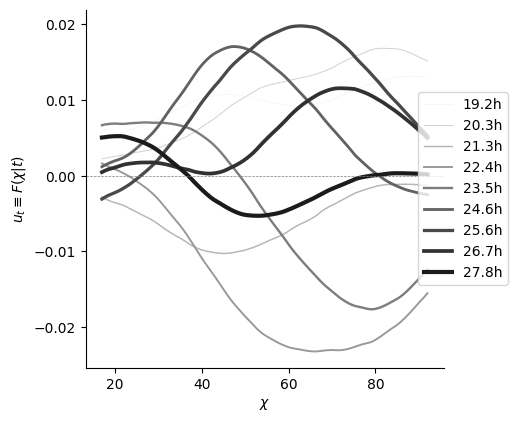

In [133]:
plot_factor = 1
ratio = 1
figure, ax = plt.subplots(figsize=(plot_factor*7.5, plot_factor*4.65), ncols = 1)
signal_matrix_space_normal_to_plot = signal_matrix_time_dt_normal.copy()
nx_linearized = np.linspace(min_nx_dx, max_nx_dx, nb_nx_points)
nt_linearized = np.linspace(min_nt, max_nt, nb_nt_points)
signal_matrix_space_normal_to_plot['nx'] = nx_linearized
end_frame = 100
start_frame = 10
delta_t = 10
chi_threshold = 17
derivative_label = 'u_t'
#angle = np.round(angle, decimals = 3)
#label = '$\\theta='+ str(np.round(math.degrees(angle),decimals=1))+'^{\circ}$'
#title = 'signal ' + quantity + ', '+ label
cmap = cc.cm.CET_L2.reversed()
gradient = np.linspace(0.4,3,int((end_frame - start_frame + 1) / delta_t))
colors = cmap(np.linspace(0,1,int((end_frame  - start_frame + 1) / delta_t)))
signal = signal_matrix_space_normal_to_plot.copy()
signal = signal[(signal['nx']>chi_threshold)]
for (time_frame, line_width, line_color) in zip(range(start_frame,end_frame ,delta_t), gradient, colors):
    plt.plot(signal['nx'], signal.loc[:,time_frame],c = line_color, linewidth = line_width,label = str(np.round(nt_linearized[time_frame],decimals = 1))+'h')
plt.axhline(y = 0, color = "gray", linestyle = "--", linewidth = 0.5)
ax.set(xlabel = r'$\chi$', ylabel = r'$ %s \equiv F(\chi|t)$' % derivative_label)
xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
ax.set_aspect(abs((xright-xleft)/(ybottom - ytop))*ratio)
#plt.annotate(r'%s' %title, xy=(0.03, 0.05), xycoords='axes fraction')
ax.legend(loc='center left', bbox_to_anchor=(0.91, 0.5))
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
#if FIGURES_DIR != '':
#    plt.savefig(os.path.join(FIGURES_DIR, slugify(title)+'.png'), format = 'png')
plt.show()

In [134]:
signal_matrix_space_normal.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.002363,0.002905,0.003495,0.004156,0.006272,0.007293,0.008013,0.008840,0.009688,0.010503,...,0.020095,0.020691,0.021276,0.022005,0.022707,0.023459,0.025565,0.026171,0.026802,0.027318
1,0.002119,0.002699,0.003326,0.004024,0.006263,0.007353,0.008125,0.009007,0.009912,0.010782,...,0.020933,0.021529,0.022114,0.022837,0.023536,0.024286,0.026363,0.026950,0.027561,0.028064
2,0.001909,0.002515,0.003168,0.003894,0.006230,0.007375,0.008190,0.009118,0.010069,0.010984,...,0.021559,0.022159,0.022748,0.023470,0.024171,0.024922,0.026990,0.027567,0.028170,0.028669
3,0.001762,0.002386,0.003060,0.003806,0.006218,0.007406,0.008254,0.009216,0.010202,0.011151,...,0.022011,0.022613,0.023204,0.023926,0.024627,0.025378,0.027437,0.028007,0.028604,0.029101
4,0.001599,0.002241,0.002932,0.003698,0.006177,0.007405,0.008284,0.009279,0.010298,0.011278,...,0.022420,0.023022,0.023613,0.024330,0.025028,0.025776,0.027818,0.028378,0.028967,0.029459


Shape of grid u_data: (100, 100)
Shape of grid u_data.T: (100, 100)
Shape of grid t: (100, 100)
Shape of grid x: (100, 100)
Shape of grid u: (100, 100)
bottom_min =  -0.036222498845422
bottom_max =  0.0560056887927362


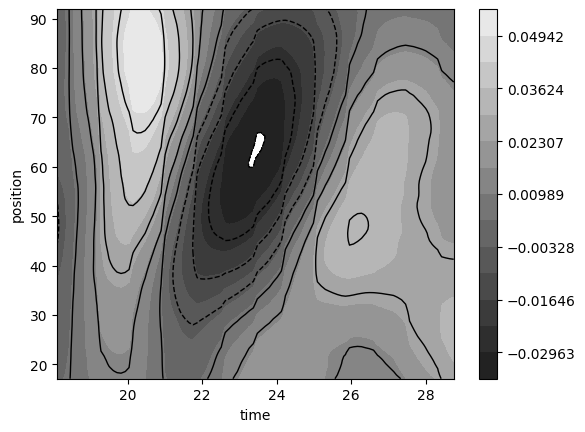

In [135]:
u_data = signal_matrix_space_normal.copy()
print('Shape of grid u_data:', u_data.shape)
u_transposed = np.real(u_data.T.to_np())
print('Shape of grid u_data.T:', u_transposed.shape)
x,t = np.meshgrid(nx_linearized, nt_linearized)
data = {}
data['t'] = t
print('Shape of grid t:', data['t'].shape)
data['x'] = x
print('Shape of grid x:', data['x'].shape)
data['u'] = u_transposed
print('Shape of grid u:', data['u'].shape)

bottom_min  : float = np.min(u)
print('bottom_min = ',bottom_min)
bottom_max  : float = np.max(u)
print('bottom_max = ',bottom_max)
fig, ax = plt.subplots()
im = ax.contourf(data['t'], data['x'], data['u'], levels = np.linspace(bottom_min, bottom_max, 15), cmap = linear_blackwhite)
#im = ax.imshow(u.T, vmin = bottom_min, vmax = bottom_max, cmap = linear_blackwhite, origin = 'lower', aspect = 1)
ax.contour(data['t'], data['x'], data['u'], levels = np.linspace(bottom_min, bottom_max, 10), colors = 'k', linewidths = 1)
ax.set_xlabel('time')
ax.set_ylabel('position')
fig.colorbar(mappable=im)
plt.show()

In [142]:
~signal_matrix_space_normal.isna()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
96,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
97,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
98,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


In [149]:
signal_matrix_space_normal[signal_matrix_space_normal.any()==bottom_max]

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
